### The NN can approximate a GP

For a single layer NN, the function can be:
$h^{(0)}_j = \phi(w^{(0)}_{j}x + b^{(0)}_j)$,
$y = \sum_j^N{(w_j^{(1)}h^{(0)}_j + b^{(1)})}$

When the weight $w$ and bias $b$ are i.i.d (independently and identically distributed).
All of the parameters are linearly distributed according to $\mathcal{U}(-\frac{1}{\sqrt{h}}, \frac{1}{\sqrt{h}})$,
where $h$ is the number of inputs of this layer.

### Derivation of the link between NN and GP
According to the Central Limit Theorem (CLT), the sum of the infinite i.i.d. variables
converges to a normal distribution.

For a singular $y$, we have
$E(y) = 0$,
$\mathrm{Cov}\left(y(x), y(x')\right) = E\left(y(x)y(x')\right) - E\left(y(x)\right)E\left(y(x')\right) $

$=E\left( \sum_i\sum_j (w^{(1)}_i w^{(1)}_j h_i h_j)+b^{(1)2}\right)$
$=\sum_i\sum_j \left( E\left(w^{(1)}_i w^{(1)}_j h_i h_j\right)\right) + \sigma_{b^{(1)}}^2$
$=\sum_i\sum_j \left( E\left(w^{(1)}_i w^{(1)}_j\right)E\left(h_i h_j\right)\right) + \sigma_{b^{(1)}}^2$

Here we have:
 $E\left(w^{(1)}_i w^{(1)}_j\right) = \delta_{ij}\sigma^2_{w^{(1)}}$, where $\delta_{ij}$ is the Dirichlet
 operator. So, the covariance can be written as:
$\mathrm{Cov}\left(y(x), y(x')\right) =\sum_i\sum_j \left( \delta_{ij}\sigma^2_{w^{(1)}}E\left(h_i h_j\right)\right) + \sigma_{b^{(1)}}^2 $,
$= \sigma^2_{w^{(1)}}  \sum_k  E\left(h_k(x) h_k(x')\right) + \sigma_{b^{(1)}}^2$

In [344]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch

# plot configuration
mpl.rcParams['figure.dpi'] = 100
# fix random seeds
axes = {'labelsize' : 'large'}
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 17}
legend = {'fontsize': 'medium'}
lines = {'linewidth': 3,
         'markersize' : 7}
mpl.rc('font', **font)
mpl.rc('axes', **axes)
mpl.rc('legend', **legend)
mpl.rc('lines', **lines)

nx = 101
x = np.linspace(-1.0, 1., nx)[:, np.newaxis]*10.

# Gaussian process

The distribution on every single $x$ should be a **Gaussian distribution**.

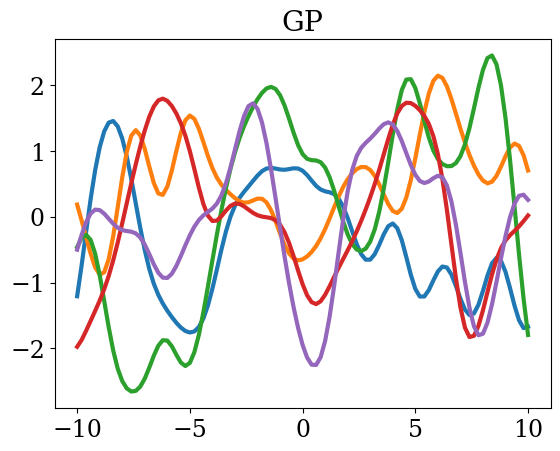

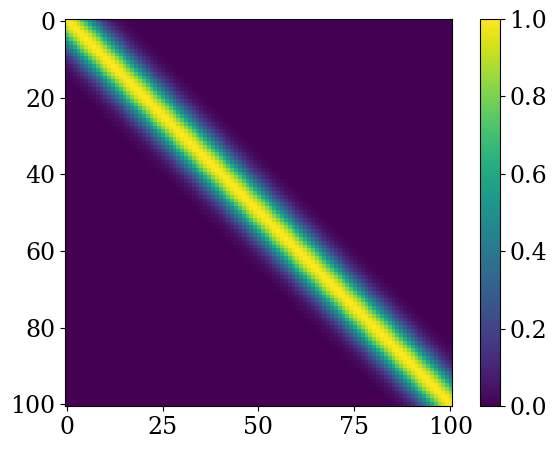

In [345]:
x_temp = -(x.T - x)**2/2.
kernel = np.exp(-(x.T - x)**2/2.)
def rand_gen_GP(num_samples = 5):
    y = np.random.multivariate_normal(mean=np.zeros(shape=nx), cov=kernel, size=num_samples)
    return y
y = rand_gen_GP()
plt.plot(x.reshape(-1), y.T)
plt.title('GP')
plt.show()

plt.imshow(kernel); plt.colorbar(); plt.tight_layout();plt.show()

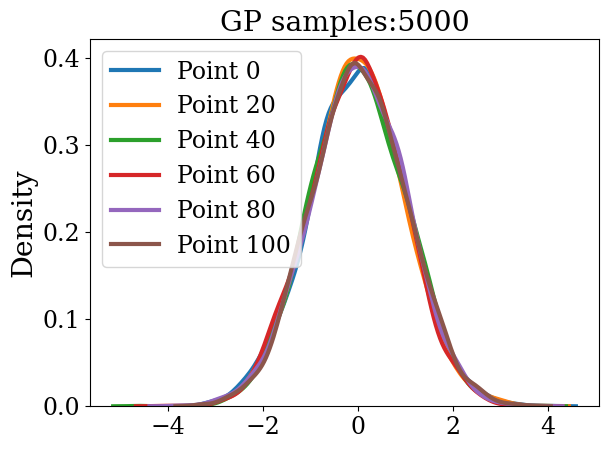

In [346]:
import seaborn as sns

num_samples = 5000

y_gp = rand_gen_GP(num_samples=num_samples)

for i in range(0, nx, nx//5):
    sns.kdeplot(y_gp[:, i], label='Point %d' % i)
plt.title('GP samples:%d' % (num_samples))
plt.legend()
plt.tight_layout()
plt.show()

# NN converges to a Gaussian process

In [347]:
class basicNN(torch.nn.Module):
    def __init__(
            self, hidden_num=100, activation='sigmoid',
            sigma_u=5.0, sigma_a=5.0, sigma_v=1.0, sigma_b=0.1):
        super(basicNN, self).__init__()
        if activation=='sigmoid':
            self.activation = torch.nn.Sigmoid()
        elif activation=='relu':
            self.activation=torch.nn.ReLU()
        elif activation == 'tanh':
            self.activation = torch.nn.Tanh()
        elif activation == 'linear':
            self.activation = self.linear_activation
        else:
            raise

        self.l1 = torch.nn.Linear(1, hidden_num, bias=False)
        self.l2 = torch.nn.Linear(hidden_num, 1, bias=False)

        # self.w1 = torch.randn(size=[1, hidden_num])*sigma_u
        # self.w2 = torch.randn(size=[hidden_num, 1])/np.sqrt(hidden_num)*sigma_v
        # self.b1 = torch.randn(size=[hidden_num]) * sigma_a
        # self.b2 = torch.randn(size=[1])*sigma_b

    def forward(self, x):
        # x = self.activation(x@self.w1 + self.b1)@ self.w2 # + self.b2
        x = self.l2(self.activation(self.l1(x)))
        return x

    def linear_activation(self, x):
        return x

## Results in Neal's thesis (Neal 1996) Page 33

$ f(x) = b_k + v_{jk} h_j(x)$

$ h_j(x) = tanh(a_j + u_{ij} x_i )$

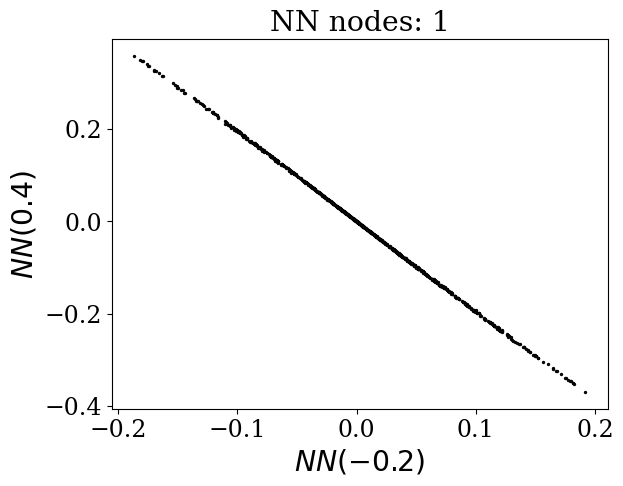

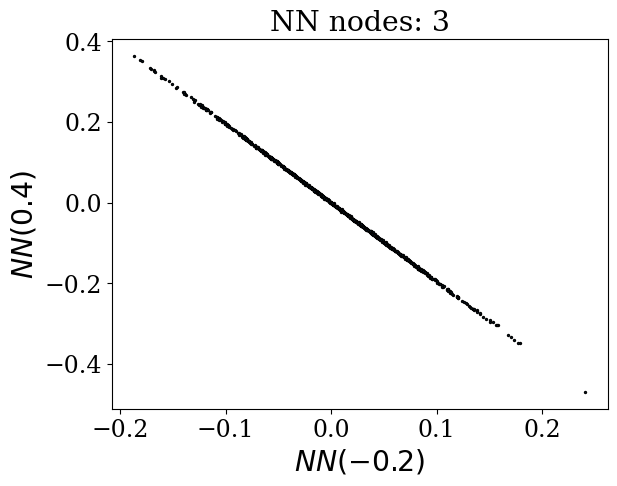

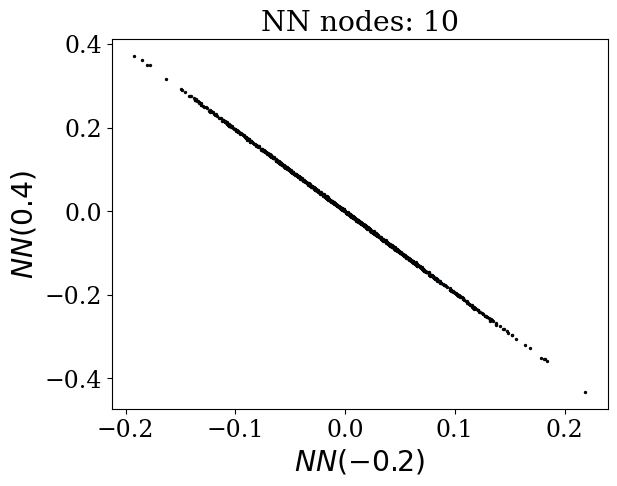

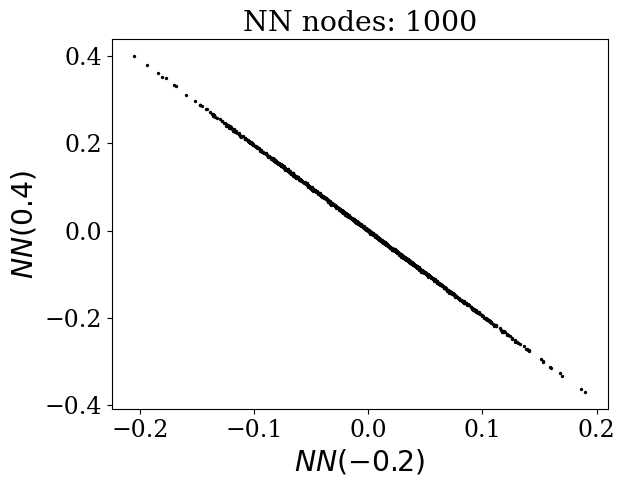

In [348]:
def neal_1996(hidden=1, num_samples=1000, activation='tanh'):
    y = []
    x_temp = np.array([-0.2, 0.4]).reshape(-1, 1)
    for i in range(num_samples):
        model = basicNN(hidden_num=hidden, activation=activation)
        with torch.no_grad():
            y.append(model(torch.from_numpy(x_temp).float()).numpy().reshape(-1))
    y = np.array(y)
    plt.scatter(y[:, 0], y[:, 1], s=2, edgecolors='k')
    plt.xlabel(r'$NN(-0.2)$')
    plt.ylabel(r'$NN(0.4)$')
    plt.title('NN nodes: %d' % hidden)
    plt.show()
    return
neal_1996(hidden=1)
neal_1996(hidden=3)
neal_1996(hidden=10)
neal_1996(hidden=1000)

In [349]:
def rand_gen_NN(hidden=100, num_samples = 5, activation='sigmoid'):
    y = []
    for i in range(num_samples):
        model = basicNN(hidden_num=hidden, activation=activation)
        with torch.no_grad():
            y.append(model(torch.from_numpy(x).float()).numpy().reshape(-1))
    return np.array(y)


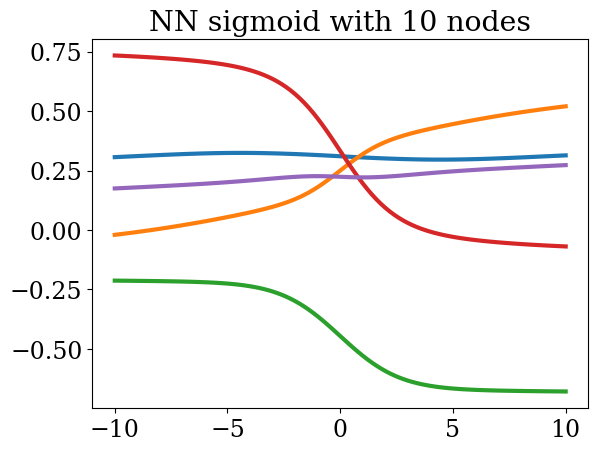

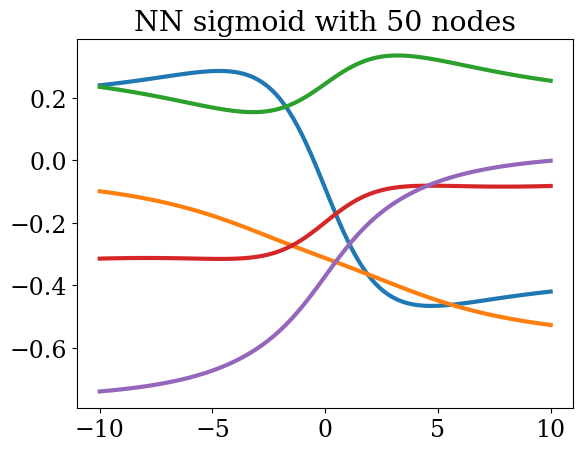

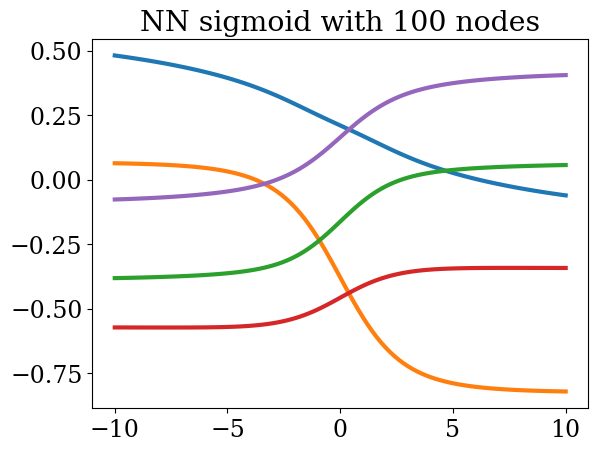

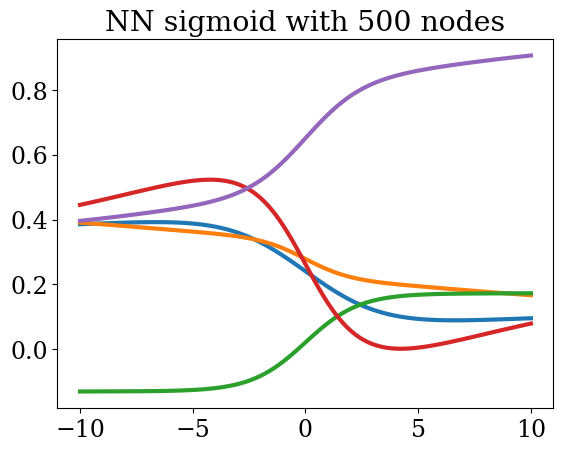

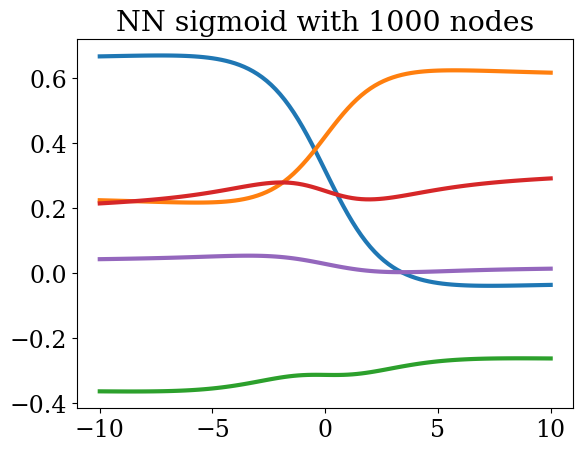

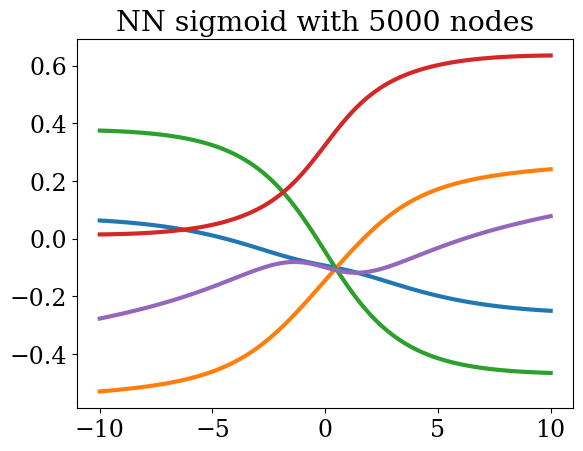

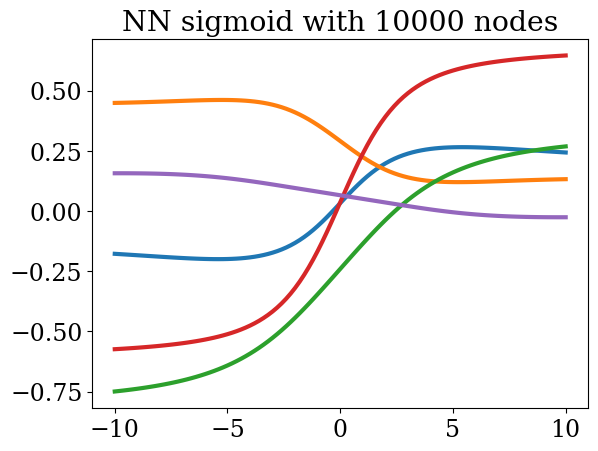

In [350]:
activation = 'sigmoid'
hidden_node_list = [10, 50, 100, 500, 1000, 5000, 10000]
for i in hidden_node_list:
    y = rand_gen_NN(hidden=i)
    plt.plot(x.reshape(-1), y.T)
    plt.title('NN %s with %d nodes' % (activation, i))
    plt.show()


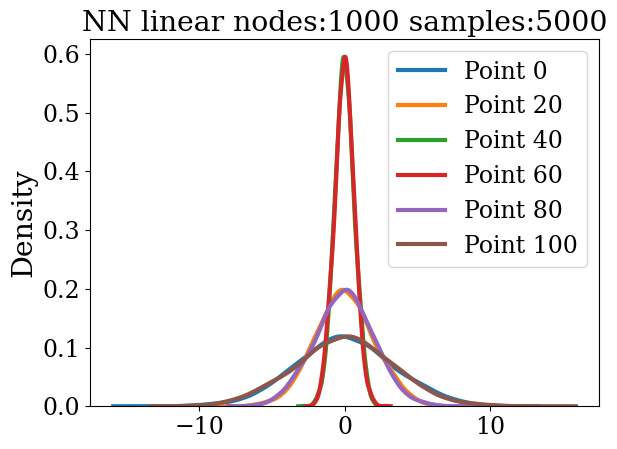

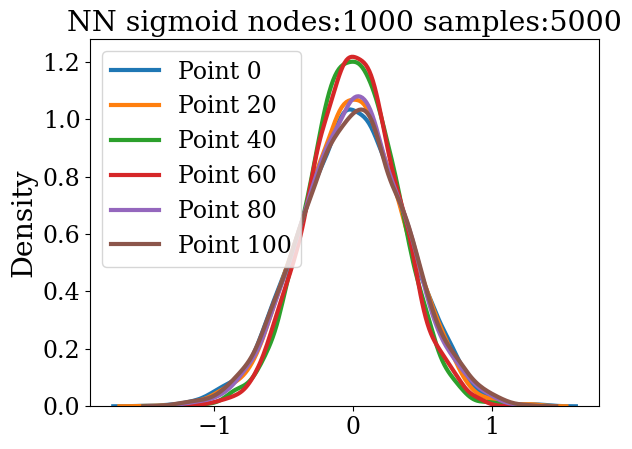

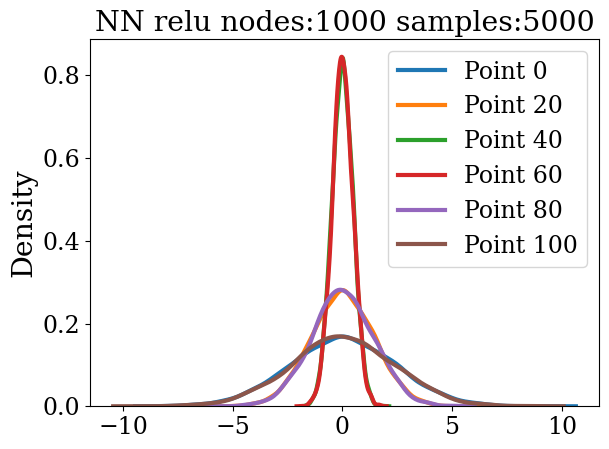

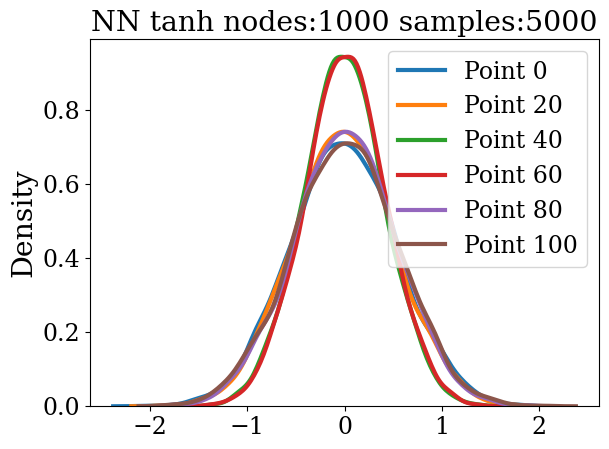

In [351]:
#TODO activation sin bessel

hidden_node_num = 1000
num_samples = 5000
activation = 'sigmoid'

def mask(hidden_node_num, num_samples, activation):
    y_nn = rand_gen_NN(hidden=hidden_node_num, num_samples=num_samples, activation=activation)

    for i in range(0, nx, nx//5):
        sns.kdeplot(y_nn[:, i], label='Point %d' % i)
    plt.title('NN %s nodes:%d samples:%d' % (activation, hidden_node_num, num_samples))
    plt.legend()
    plt.tight_layout()
    plt.show()
    return

for act_temp in ['linear', 'sigmoid', 'relu', 'tanh']:
    mask(hidden_node_num=hidden_node_num, num_samples=num_samples, activation=act_temp)

Comparing the three activation functions, we can find that the $Sigmoid$ activation function can
make the NN perform more similarly to the Gaussian Process.

The $Relu$ and $Tanh$ behaves poor. Should the reason be that these two are **not derivative**?

**But why the linear behaves like this**?


# Numerical integration of the NN kernel

$\mathrm{Cov}(y, y') = E (y \cdot y') - E(y) \cdot E(y') = E \left( \left( w_1 (w_0x+b_0 )+b_1 \right) \cdot \left( w_1 (w_0 x'+b_0 )+b_1 \right) \right) \\$
$ = $

**Why the kernel is not like the kernel of the RBF kernel??**

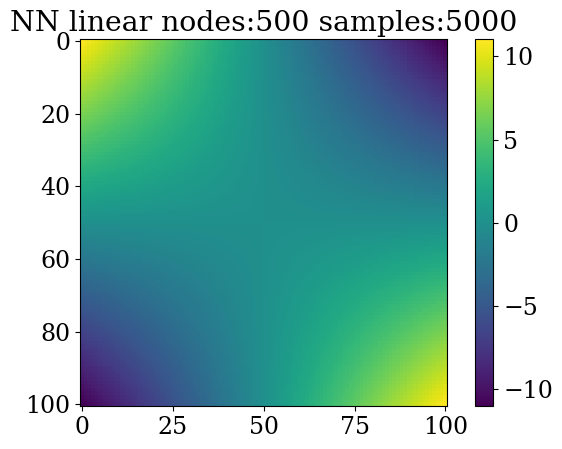

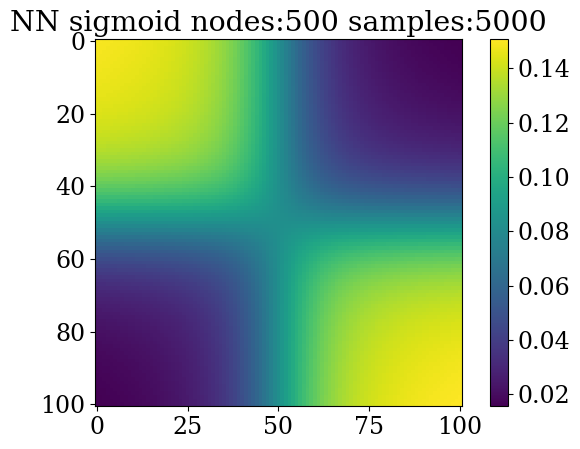

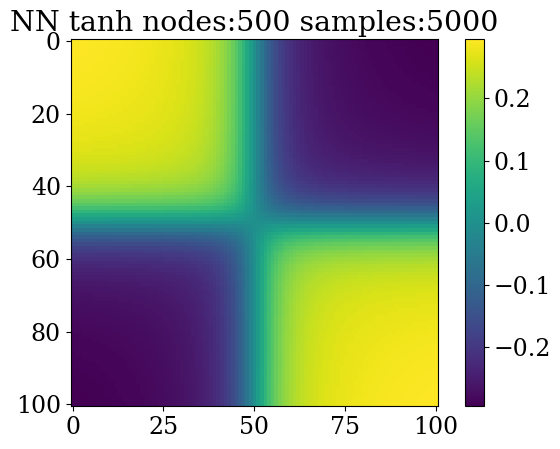

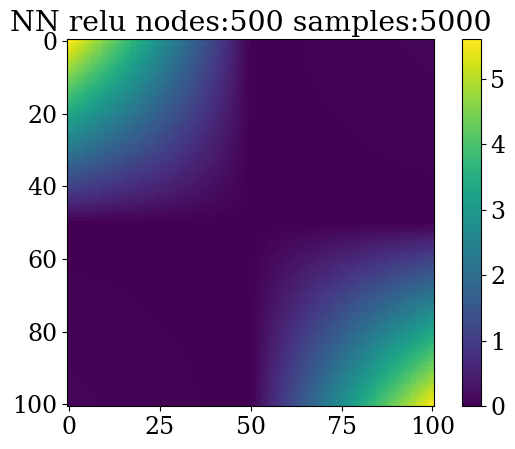

In [352]:
hidden_node_num = 500
num_samples = 5000

activation = 'sigmoid'
def plot_nn_kernel(activation):
    y_nn = rand_gen_NN(hidden=hidden_node_num, num_samples=num_samples, activation=activation)

    k_nn = np.einsum('mi, mj->ij', y_nn, y_nn)/num_samples

    plt.imshow(k_nn)
    plt.colorbar()
    plt.title('NN %s nodes:%d samples:%d' % (activation, hidden_node_num, num_samples))
    plt.tight_layout()
    plt.show()
    return
for i in ['linear', 'sigmoid', 'tanh', 'relu']:
    plot_nn_kernel(activation=i)